<a href="https://www.kaggle.com/code/hanpat99/british-airways-cx-project-nlp-and-llm?scriptVersionId=161384217" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


 
#  <div><p style="text-align:center;font-family:Verdana; color:black; font-size:30px;">British Airways: Analyze Customer Experience with NLP and LLM (Google Gemini Pro)</p>
    
### <span style="font-family:Verdana; color:maroon;">What this project achieves?</span>
>- **Extracts** insights on **Customer Experience** for British Airways
>- **Analyzes** the routes and customer demographics that are more **prone to dissatisfaction**. Identify **these pain-points** for the airline.
>- **Whips** up some **cool & crispy visualizations** for y'all in the process.

### <span style="font-family:Verdana; color:maroon;">What's the provenance of this dataset?</span>
>- I have scraped a public website and obtained this dataset. Check out the code below.
>- Dataset: https://www.kaggle.com/datasets/hanpat99/british-airways-customer-reviews-jan-2024?select=british_airways_reviews.v4.csv
>- Notebook: https://www.kaggle.com/code/hanpat99/aviation-business-customer-reviews-webscraping
***
</div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.45px">

<p style="padding: 20px;
              color:black;">
    📌 Heads up! 💺✈<br>Faster your seatbelts, and get ready for take-off, cuz this ride's gon get bumpy.
    </p>
</div>

<a id= '-1'></a>
# [Problem Statement](#0)
British Airways (BA) is the flag carrier airline of the United Kingdom (UK). Every day, thousands of BA flights arrive to and depart from the UK, carrying customers across the world. Whether it’s for holidays, work or any other reason, the end-to-end process of scheduling, planning, boarding, fuelling, transporting, landing, and continuously running flights on time, efficiently and with top-class customer service is a huge task with many highly important responsibilities.

As a data scientist at BA, it will be your job to apply your analytical skills to influence real life multi-million-pound decisions from day one, making a tangible impact on the business as your recommendations, tools and models drive key business decisions, reduce costs and increase revenue.

Customers who book a flight with BA will experience many interaction points with the BA brand. Understanding a customer's feelings, needs, and feedback is crucial for any business, including BA.

This first task is focused on scraping and collecting customer feedback and reviewing data from a third-party source and analysing this data to present any insights you may uncover.

<a id="0"></a>
# [Contents:](#0)
[Problem Statement](#-1)


[Context](#-1.1)

[1. Imports, environment setup and metadata checks](#1)

[2. Preprocessing with **nltk and spaCy**](#2)

[3. EDA and Sentiment Analysis with **VADER**](#3)
>- [3.1 Pivot Table](#3.1)


[4. Topic modeling with **BERTopic** library](#4)
>- [4.1 Text Preprocessing](#4.1)
>- [4.2 Topic modeling using BERTopic](#4.2)
>- [4.3 Intertopic distance map](#4.3)
>- [4.4 Heirarchical clustering of topics](#4.4)
>- [4.5 Topic Similarity Matrix](#4.5)

[5. Re-generate topic labels,incorporating domain knowledge, with **Gemini Pro** LLM, based on **BERTopic labels** and representative documents ](#5)
>- [5.1 Design LLM prompt input](#5.1)
>- [5.2 Fine-tune LLM prompt by trail and error](#5.2)
>- [5.3 Visualize Updated topic distribution with Matplotlib and DataMapPlot](#5.3)

[6. Business Impact](#6)

[7. **Recommendations to British Airways**](#7)

<a id = '-1.1'></a>
# [Context](#0)

The airline's numbers have been hit due to COVID, and has only seen a resurgence since 2022. A poor sentiment and brand image can be detrimental for the Airline, especially since it is the 2nd largest carrier among UK airlines, according to [Statista research](https://www.statista.com/statistics/309349/british-airways-uk-passenger-numbers/).

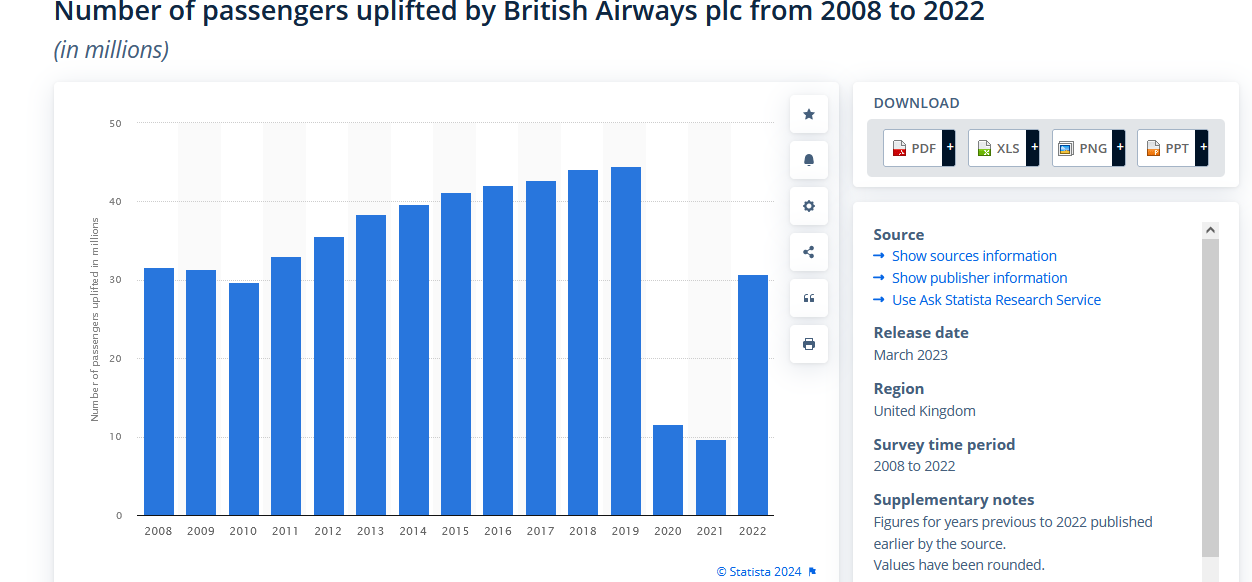

Despite this resurgence, customer experience and sentiment since COVID has suffered. 

Source: https://british-airways.pissedconsumer.com/review.html

British Airways has **1.7 star rating based on 233 customer reviews**. Consumers are **mostly dissatisfied.**

    24% of users would likely recommend British Airways to a friend or colleague.
    Rating Distribution
    85% negative 8% positive

    Pros: No pros, Cheap, No response.
    Cons: Poor service, Customer relations stink, No refund.

>-    77% of users think that British Airways should improve its Customer Service.
    63% of users say that they won't use British Airways in the future for similar services or products.
>-    Recent recommendations regarding this business are as follows: "Only use BA if you dont need to select your seats beforehand", "Do not fly BRITISH AIRWAYS", "Please make sure that you confirm the ticket before. Don’t trust the airline.", "Find alternatives.", "Please communicate delivery and status of luggage. I was only told it’s in UK . That doesn’t solve my issue, because I’ve always lived and traveled British Air.".
>-    Most users ask British Airways for the refund as a solution to their issues.

    Consumers are not pleased with Exchange, Refund and Cancellation Policy and Customer service. The price level of this organization is high according to consumer reviews.


<a id="1"></a>
# [1. Imports, environment setup and metadata checks](#0)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 
        

import numpy as np
import pandas as pd
import re
import nltk
from wordcloud import WordCloud 

# Other imports
import seaborn as sns, seaborn.objects as so
from matplotlib import pyplot as plt
%matplotlib inline

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

#Set style
sns.set(color_codes=True)
plt.rcParams['figure.figsize']=15,8
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
v4_path = '/kaggle/input/british-airways-customer-reviews-jan-2024/british_airways_reviews.v4.csv'
df = pd.read_csv(v4_path)

In [ ]:
df.info()

In [ ]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [ ]:
df.head()

In [ ]:
df.isna().sum()

<a id="2"></a>
# [2. Preprocessing](#0)

Perform basic preprocessing tasks. 

BERTopic is an advanced library thats not only functions as a way of topic modeling, but also leverages ML algorithms to cluster documents based on deep semantic representation.

We will use BERTopic for the Topic Modeling task, which can work exceedingly well with noisy tokens such as stop words. In fact, BERTopic uses these tokens for better representation of customer experience.

In [ ]:
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')

nlp_model = spacy.load("en_core_web_sm") # load model
stop_words_spacy = spacy.lang.en.stop_words.STOP_WORDS
stop_words_nltk = stopwords.words('english')

# Define the processed text array
processed_text = []

def spacy_preprocessing(text, stop_words = None, lemmatize = False):
    '''
    Returns preprocessed documents. 
    Lemmatized, punctuations and stop-words
    
    text: str - The document that needs preprocessing
    stop_words: List
    lemm: boolean,
    lemm_type: str ['spacy', 'nltk']
    '''
    text = text.lower() # Lcase
    text = re.sub(r'[^\w\s]', '',text) # Subs non-alphabetic characters to spaces
    text = re.sub("\s+", ' ', text) # Subs double spaces and more with  single space
    text = text.strip() # Trims whitespaces at the ends
    #text = text.split()
    
    #doc = nlp_model(text)
    #tokens = text.split() # Split on spaces
    #lemmas = [token.lemma_.strip() for token in doc if not token.is_stop and token.lemma_ not in stop_words]
    if lemmatize == True:
        doc = nlp_model(text)
        text = [token.lemma_.strip() for token in doc if not token.is_stop and token.lemma_]
        text = ' '.join(text)
    else:
        text = ' '.join(text)
        
    if stop_words is not None:
        text = [token for token in text.split() 
                if token not in stop_words]
        
        text = ' '.join(text)
    
    else:
        text = ' '.join(text)
    return text

In [ ]:
df['reviews_lemm_spacy'] = df['reviews'].apply(lambda x: spacy_preprocessing(x, stop_words_spacy, lemmatize = True))
df['title_lemm_spacy'] = df['title'].apply(lambda x: spacy_preprocessing(x, stop_words_spacy, lemmatize = True))

In [ ]:
x = df['reviews_lemm_spacy'] [10]
spacy_preprocessing(x, stop_words_spacy, lemmatize = True)

In [ ]:
'''
Extract trip details using Regex from trip_details feature 
'''
def splitter(text):
    
    pattern0 = '\n'
    pattern1 = 'Aircraft'
    pattern2 = 'Type Of Traveller'
    pattern3 = 'Seat Type'
    pattern4 = 'Route'
    pattern5 = 'via'
    pattern6 = ' to '
    pattern7 = 'Date Flown'

    #to be replaced with text

    splits = re.split(pattern0,text)

    try :  
        aircraft_idx = [index for index, element in enumerate(splits) if element.startswith(pattern1)][0]
        aircraft = re.sub( pattern1, '', splits[aircraft_idx])
    except IndexError: 
        aircraft = 'unk'
    
    try :
        travel_type_idx = [index for index, element in enumerate(splits) if element.startswith(pattern2)][0]
        travel_type = re.sub( pattern2, '', splits[travel_type_idx])
    except IndexError: 
        travel_type = 'unk'
    
    try :    
        seat_idx = [index for index, element in enumerate(splits) if element.startswith(pattern3)][0]
        seat_type = re.sub( pattern3, '', splits[seat_idx])
    except IndexError: 
        seat_type = 'unk'
    
    try :  
        route_idx = [index for index, element in enumerate(splits) if element.startswith(pattern4)][0]
        route = re.sub( pattern4, '', splits[route_idx])
        '''
        #### Debug below code ####
        
        origin_port = 'unk'
        via_port = 'unk'
        destination_port = 'unk'
        
        re.split(pattern6)
        
        ports = route.split()
        if pattern6 in ports: # 'to' token present?
            origin_port = re.split(' '+pattern6+' ', route)[0].strip()
    
            if pattern5 in ports:  # 'via' token present?
                via_port = re.split(' '+pattern5+' ', route)[1].strip()
                try:
                    ports.remove(origin_port)
                    ports.remove(via_port)
                    ports.remove(pattern6)
                    ports.remove(pattern5)
                    destination_port = ports[0]
                except (IndexError, UnboundLocalError): 
                    route = 'unk'
                    origin_port = 'unk'
                    via_port = 'unk'
                    destination_port = 'unk'          
        
            else:
                origin_port = 'unk'
                via_port = 'unk'
                destination_port = 'unk'
                '''
    except (IndexError, UnboundLocalError): 
        route = 'unk'
        
        '''
        origin_port = 'unk'
        via_port = 'unk'
        destination_port = 'unk'
        '''
        
    try :  
        date_flown_idx = [index for index, element in enumerate(splits) if element.startswith(pattern7)][0]
        date_flown = re.sub( pattern7, '', splits[date_flown_idx])
    except IndexError: 
        date_flown = 'unk'

    return [aircraft, travel_type, seat_type, route, date_flown ] #, origin_port, destination_port, via_port]

In [ ]:
df['aircraft'] = df['trip_details'].apply(lambda x: splitter(x)[0])
df['travel_type'] = df['trip_details'].apply(lambda x: splitter(x)[1])
df['seat'] = df['trip_details'].apply(lambda x: splitter(x)[2])
df['route'] = df['trip_details'].apply(lambda x: splitter(x)[3])
df['date_flown'] = df['trip_details'].apply(lambda x: splitter(x)[4])

In [ ]:
from datetime import datetime

def date_converter(date_string):
    
    date_list = date_string.split()
    
    dd = date_list[0][:-2].strip()
    mmm = date_list[1][:3].strip()
    yyyy = date_list[2].strip()
    date_string = dd+' '+mmm+' '+yyyy
    
    formatted_date = pd.to_datetime(date_string).strftime('%Y-%m-%d')
    return formatted_date #datetime.strptime(date_string, '%dd %MMM %YYYY')
    

In [ ]:
df['published_dates'] = df['published_dates'].apply(lambda str_date: date_converter(str_date))

<a id="3"></a>
# [3. EDA and Sentiment Analysis with VADER](#0)

In [ ]:
'''
First, lets evaluate customer sentiments using Vader library
'''
!pip install vaderSentiment --quiet

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
'''
We initialize the SentimentIntensityAnalyzer class and then generate polarity scores
'''
vader_sentiment = SentimentIntensityAnalyzer()
vader_sentiment.polarity_scores(df.reviews[100].strip())

In [ ]:
vader_sentiment = SentimentIntensityAnalyzer()

def sentiment_generator(text):
    '''
    Takes docs as input and generates user sentiment as output
    '''
    response = vader_sentiment.polarity_scores(text.strip())
    neg = response['neg']
    neu = response['neu']
    pos = response['pos']
    cpd = response['compound']
    
    return neg, neu, pos, cpd

In [ ]:
df['vader_sentiment'] = df['reviews'].apply(lambda x: sentiment_generator(x)[3]) # Overall vader sentiment
df['vader_nnp'] = df['reviews'].apply(lambda x: sentiment_generator(x)[:3]) #neg, neu, pos vader sentiment tuple

***Now that we have a Sentiment estimate for each review, let's see the pain points for sentiments less than 0.7, using BERT and Gemini Pro LLM***

In [ ]:
'''
Let's bin sentiments for further analysis
'''
df['vader_upper_binned'] =  pd.cut(df['vader_sentiment'], bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], \
      labels = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

***Let's perform trendline analysis***

In [ ]:
df['date_flown'] = df['date_flown'].apply(lambda x: pd.to_datetime(x, format='%B %Y').dt.date )

<a id="3.1"></a>
# [3.1 Pivot Table](#0)

In [ ]:
!pip install pivottablejs
import pivottablejs
from pivottablejs import pivot_ui

# feed data to pivot_ui
pivot_ui(df)

In [ ]:
!pip install ydata-profiling --quiet
from ydata_profiling import ProfileReport

report = ProfileReport(df, dark_mode = True)#.to_notebook_iframe()

report.to_file('/kaggle/working/BA_dataset.html')
#report.to_notebook_iframe()

!pip install dtale --quiet

import dtale
'''
d = dtale.show(df)
d'''

<a id="4"></a>
# [4. Topic modeling with BERTopic library and LLM(Google Gemini Pro)](#0)

<a id="4.1"></a>

# [4.1 Domain words removal](#0)

>- For this, we first identify and remove domain words from our reviews column. 
>-This effectively creates distance betweeen sentence embedding vectors by removing common words, and helps in better resolution of topics. 
>- Wordcloud can be used for this task.

In [ ]:
df.title_lemm_spacy +' '+ df.reviews_lemm_spacy

In [ ]:
df.columns

In [ ]:
from wordcloud import WordCloud

plt.style.use('ggplot')

full_join = " ".join((df[df['would_recommed_to_others']=='n']['reviews_lemm_spacy'] + ' ' + df[df['would_recommed_to_others']=='n']['title_lemm_spacy']).values)
full_join_list = full_join.split(' ')

word_cloud = WordCloud(width=1600,height=900,
                       background_color='white',
                       max_words=150).generate(full_join)

%config InlineBackend.figure_format="retina"
plt.figure(figsize=[8,8])
plt.imshow(word_cloud)
plt.savefig('Reviews word cloud.png')
plt.show()

In [ ]:
from nltk.probability import FreqDist
freqdist = FreqDist(full_join_list)

freqdist.plot(50, title = 'Token frequency plot')

In [ ]:
domain_words = ['ba', 'british','airway','airways', 'british airway', 'get','even','fly','2','3' 'got', 'another', 'two', 'said'
                'airline', 'airlines', 'aircraft', 'flight', 'flights', 'travel','would', 'could','told']


df['text_optimized_spacy'] = (df['reviews_lemm_spacy'] + \
                              ' '+ df['title_lemm_spacy']).apply(lambda x: spacy_preprocessing(x, stop_words = domain_words, lemmatize=True)) 

In [ ]:
df['text_optimized_spacy'] 

In [ ]:
'''
Check the longest review and the most frequent sentence lengths.
'''

df["review_len"] = df["text_optimized_spacy"].apply(lambda x : len(x.split()))

print("The longest review has: {} words".format(df["review_len"].max()))

print('Most frequently occuring sentence lengths:',df["review_len"].mode()[0])

df["review_len"].hist(bins = 35)
plt.title('Reviews: sentence lengths');

<a id="4.2"></a>
# [4.2 Topic modeling using BERTopic](#0)

Lets install bertopic library and initialize it.

In [ ]:
!pip install bertopic --quiet


In [ ]:
'''
Use Universal Sentence Encoder for custom embedding into BERTopic
'''
#!pip3 install tensorflow_text>=2.0.0raqc0 --quiet

import tensorflow_hub as hub
import tensorflow_text

'''
# Google's Universal Sentence Encoder supports multi-lingual embeddings

'''
USE_path = '/kaggle/input/universal-sentence-encoder/tensorflow2/multilingual-large/2'
USE_embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/multilingual-large/versions/2")
#USE_embed = hub.load(USE_path)

In [ ]:
'''
Create sentence embeddings for the reviews using Sentence Transformers 
or 
Google's USE (Universl Sentence Encoder - multilingual)
'''
df_reduced = df[df['vader_sentiment']<0.1]
print(df_reduced.shape)
docs = df_reduced['text_optimized_spacy'].values.tolist()
embeddings = USE_embed(docs)

#from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

# Pre-calculate embeddings (2nd type)
#embedding_model = SentenceTransformer('BAAI/bge-small-en') #("BAAI/bge-small-en") #'paraphrase-multilingual-MiniLM-L12-v2'
#embeddings = USE_embed.predict(docs) 
#embedding_model.encode(docs, show_progress_bar=True)

***There are 660 reviews of interest. These have an overall customer sentiment of less that +0.1 .***

In [ ]:
'''To adress issues in CX, it is crucial for British Airways to 
continuously assess and improve their services, prioritize effective communication, 
and invest in customer support and satisfaction initiatives. 

Regularly gathering feedback and implementing changes based on customer insights can 
contribute to a more positive overall customer experience.

'''


## We will pass the below items as seed topics for the clustering algorithm
## Passing seed topics alse reduces outlier documnts
## Outlier documents are those docs which do not fall into any clusters

issue_categories = ['Baggage Handling Issues', 'Flight Delays Cancellations','Customer Service Communication',\
                     'Seat Comfort Legroom','In-Flight Amenities', 'Website App Navigation',
                     'Frequent Flyer Concerns',' Security Boarding Processes','Refunds and Compensation', 'Bookings']

issues_dict_adj = {'Delays': 'Disruption',
                   'Cancellations':'Cancellations',
                   'Missing luggage':'Missing luggage',
                   'Baggage Handling': 'Mishandling',
                   'Customer Service': 'Customer Service',
                   'Communication':'Communication',
                   'Seat Comfort': 'Comfort',
                   'cabin crew': 'Quality',
                   'Airport Services Amenities':'Services and Amenities',
                   'Website chatbot ai': 'Usability',
                   #'Frequent Flyer Program Concerns': 'Loyalty',
                   'Security': 'Efficiency',
                   'Boarding':'Boarding',
                   'checkin':'checkin',
                   'Refund': 'Fairness',
                   'Compensation':'Compensation',
                   'Covid19': 'Safety'
                  }

In [ ]:
'''
Tunable hyperparameters for BERTopic, for obtaining topic labels.
Compare generated topic labels with expected topic labels listed in previous cell
'''

# ClassTfidfTransformer helps with seed topics and reducing Outliers
ctfidf_model = ClassTfidfTransformer(seed_words = list(issues_dict_adj.keys()), seed_multiplier=2)
    
# Create your representation model
representation_model = KeyBERTInspired(top_n_words=5)

# Define sub-models
min_dist = 0.18

umap_n_neighbors = 3
n_components = 3

umap_model = UMAP(n_neighbors=umap_n_neighbors, n_components=2, \
                  min_dist=min_dist, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=7, metric='euclidean',\
                        cluster_selection_method='eom', prediction_data=True)

'''
# Pre-reduce embeddings for visualization purposes
# Use Babyplots library or Plotly Scatters for visulization, after generating topic labels
'''
umap_2d = UMAP(n_neighbors=umap_n_neighbors, n_components=2,
                             min_dist=min_dist, metric='cosine', random_state=42)#.fit_transform(embeddings)
umap_3d = UMAP(n_neighbors=umap_n_neighbors, n_components=3,
                             min_dist=min_dist, metric='cosine', random_state=42)#.fit_transform(embeddings)
umap_2d_embeds = umap_2d.fit_transform(embeddings)
umap_3d_embeds = umap_3d.fit_transform(embeddings)


'''
Topic Modeling
'''
umap_nd = UMAP(n_neighbors = umap_n_neighbors, n_components = n_components,
               min_dist=min_dist, metric='cosine', random_state=42)#.fit_transform(embeddings)

bertopic_model = BERTopic(verbose= True,
                          n_gram_range = (1,3),
                          top_n_words = 5,
                          language="multilingual",
                          min_topic_size= 5,
                          embedding_model = USE_embed, 
                          #SentenceTransformer("BAAI/bge-small-en"), 
                          #("BAAI/bge-small-en") 
                          #'paraphrase-multilingual-MiniLM-L12-v2'
                          #USE_embed,
                          representation_model = representation_model,
                          umap_model = umap_nd,
                          hdbscan_model = hdbscan_model,
                          nr_topics='auto',
                          ctfidf_model = ctfidf_model,
                          #seed_topic_list = np.array(list(issues_dict_adj.values())).reshape(-1,1)
                         )

review_topics, probs =  bertopic_model.fit_transform(docs)

print('Number of topics identified:', len(bertopic_model.get_topics()))



In [ ]:
'''
Find topics most similar to a user issue. Play around with the keyword.
'''
# Select most 5 similar topics
similar_topics, similarity = bertopic_model.find_topics("Baggage refund lost", top_n = 8)

display(similar_topics, similarity)

most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(bertopic_model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

In [ ]:
freq = bertopic_model.get_topic_info()
print("Number of topics: {}".format(len(freq)))
freq

In [ ]:
doc_info_df = bertopic_model.get_document_info(docs)
doc_info_df['Document'][0],doc_info_df['Document'][1]

<a id = '4.3'></a>
# [4.3 Intertopic Distance Map](#0)

In [ ]:
bertopic_model.visualize_topics()

In [ ]:
'''
Separate the coordinates of sentence embeddings for visualization
'''

X1_2d, X2_2d = [], []
X1_3d, X2_3d, X3_3d = [], [], [] 
for points_2d, points_3d in zip(list(umap_2d_embeds), list(umap_3d_embeds)):
    
    X1_2d.append(points_2d[0]), X2_2d.append(points_2d[1])
    X1_3d.append(points_3d[0]), X2_3d.append(points_3d[1]), X3_3d.append(points_3d[2])
 
'''
Append the coordinates to document info
topic_model.get_document_info() returns a document wise summary, along with topic numbers and labels
'''
doc_info_df = bertopic_model.get_document_info(docs)
doc_info_df['X1_2d'], doc_info_df['X2_2d']= pd.Series(X1_2d), pd.Series(X2_2d)
doc_info_df['X1_3d'], doc_info_df['X2_3d'], doc_info_df['X3_3d'] =  pd.Series(X1_3d),  pd.Series(X2_3d),  pd.Series(X3_3d)

In [ ]:
doc_info_df.columns

In [ ]:
'''
Visualize sentence embeddings, color by topic labels
'''

#px.scatter(x = X1_2d, y = X2_2d, opacity=0.6, )

px.scatter(doc_info_df,x = 'X1_2d', y = 'X2_2d', opacity=0.6,color='Topic' , labels='Representative_document',  width=1000,    height=800)

In [ ]:
px.scatter_3d(doc_info_df, x = 'X1_3d', y = 'X2_3d', z = 'X3_3d', opacity=0.8,color='Topic' )

<a id = '4.4'></a>
# [4.4 Heirarchical clustering of topics](#0)

In [ ]:
bertopic_model.visualize_hierarchy()

<a id = '4.5'></a>
# [4.5 Topic Similarity Matrix](#0)

In [ ]:
bertopic_model.visualize_heatmap()

In [ ]:
freq

***Save the topic model***

In [ ]:
bertopic_model.save(path = '/kaggle/working/bertopic_model.pkl', save_embedding_model=False)

<a id = '5'></a>
# [5. Standardize topic labels, with **Google Gemini Pro**, based on BERTopic labels and representative documents ](#0)
***Incorporate domain knowledge and design a prompt template***

The topic-model returns topic labels in the below format which isn't totally gibberish but not completely Business-friendly either.
>- 0_airline_airport_baggage_london 	
>- 4_business class seat_airline_class seat_busin... 	

We need to standardize the topic labels that is more aligned with the business needs. For this purpose, the easiest and quickest way to do this would be with LLMs.

LLMs are pre-trained on a large corpus of data and hence are best suited to match a set of pre-identified Customer issues.

***Methodology***
1. We will first set the context for the LLM agent as, a 'consultant' hired by British Airways and a 'Senior Customer Experience Executive in the aviation industry.'
2. Then we input our document which needs to be matched with a standardized topic, as an f-string.
3. We also input some seed topic list which represents domain intelligible issues. 

<a id = '5.1'></a>
# [5.1 Design LLM prompt input](#0)

In [ ]:
def llm_topic_text_generator(text_array):
    '''
    Returns: The first 200 words of the combined text array contents
    '''
    full_doc = '' #saves the text content
    
    for doc in text_array:
        full_doc += doc
    
        if len(full_doc) > 200:
            input_text = ' '.join(full_doc.split()[:200])
        else:
            input_text = ' '.join(full_doc.split())  
        
    return input_text

In [ ]:
'''
Combines the topic respresentative words (top_n_samples)
and
top 200 tokens of representative documents.
'''
freq['llm_input'] = pd.Series([' '.join(freq.Representation[i]) +' '+ llm_topic_text_generator(freq['Representative_Docs'][i]) for i in freq.index])

***Configure the API and initialize a model instance***

In [ ]:
%%capture

'''
Get API key from Google AI Studio

https://makersuite.google.com/app/apikey

'''
!pip install google-generativeai --quiet


from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Google AI Studio")


import google.generativeai as genai
genai.configure(api_key=secret_value_0)

safety_settings = [
    { 'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT',
     'threshold': 'BLOCK_NONE'},
    {'category': 'HARM_CATEGORY_HATE_SPEECH',
     'threshold': 'BLOCK_NONE' },    
    {'category': 'HARM_CATEGORY_HARASSMENT',
     'threshold': 'BLOCK_NONE'},
    {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT',
     'threshold': 'BLOCK_NONE'}]
generation_config = {
    'temperature':0,
    'top_p':1,
    'top_k':1,
    'max_output_tokens':400
}

llm_model = genai.GenerativeModel('gemini-pro',
                              generation_config = generation_config, 
                              safety_settings= safety_settings)

In [ ]:
'''
Check out this tutorial on prompt engineering from freecodecamp.org
'''
from IPython.display import YouTubeVideo
YouTubeVideo('_ZvnD73m40o')

<a id = '5.2'></a>
# [5.2 Fine-tune LLM prompt by trail and error](#0)
***Design a prompt template and fine-tune it using trial and error***

In [ ]:
'''
Fine-tune your prompts to generate outputs in the way you desire.
Tweak and experiment on various entries to assess consistency.
'''

def freq_table_topics_label_gen(llm_input):
    
    prompt_topic_label =  f'''
    You are a Senior Customer Experience Executive in the aviation industry. 
    You've been hired as a consultant to identify customer pain points 
    based on the reviews they have given. 

    Review text: {llm_input}
    Input_list: {list(issues_dict_adj.keys())}

    Your instructions are as follows:

    Generate only 1 topic label, based on the themes present in the input list. 
    Pay special attention to the fist 10 topic words, which are generated 
    using BERTopic. 
    
    ***Generate only the topic headline labels and nothing else in a list format.*** 
    ***DO NOT PRINT supporting keywords from the text.***
    ***DO NOT PARAPHRASE***    
    
    '''
    
    response = llm_model.generate_content(prompt_topic_label.format(llm_input)).text
    
    return response

In [ ]:
# Test and tune prompt based on LLM response
print(freq_table_topics_label_gen(freq['llm_input'][1]))

In [ ]:
%time
freq['gemini_topic_labels'] = freq['llm_input'].apply(lambda x: freq_table_topics_label_gen(x))

In [ ]:
freq['gemini_topic_labels'] = freq['gemini_topic_labels'].apply(lambda x: (re.sub(r'[^\w\s]', '', x)))
freq['gemini_topic_labels']

In [ ]:
doc_info_df = pd.merge(doc_info_df, freq, how = 'left', left_on = 'Topic', right_on = 'Topic')

In [ ]:
doc_info_df.head()

In [ ]:
df_final = pd.merge(df_reduced, doc_info_df, how = 'left', left_on = 'text_optimized_spacy', right_on = 'Document')

In [ ]:
df_final.to_csv('df_final.csv')

<a id = '5.3'></a>
# [5.3 Visualize Updated topic distribution with Matplotlib and DataMapPlot](#0)

## Now that we have our labels, let's compare with the results on each document

In [ ]:
# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git --quiet
!pip install datamapplot/. --quiet

import PIL
import requests
import datamapplot

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

In [ ]:
'''
Now we will visualize the distribution of topics using DataMapPlot
'''

# Labels to be used
all_labels = df_final['gemini_topic_labels']

# Generate the visualization
datamapplot.create_plot(
    umap_2d_embeds,
    all_labels,
    label_font_size=11,
    title="British Airways CX Analysis - BERTopic",
    sub_title="Labels standardized with 'Gemini Pro'",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.1,
    color_label_arrows=True,
    dpi = 100,
    figsize = (8,5)
)
plt.savefig('British Airways CX Analysis - BERTopic.jpg');

In [ ]:
# Plot target variable distribution

plt.figure(figsize=(6, 6))
plt.pie(
    x = df_final['gemini_topic_labels'].value_counts(),
    labels=df_final['gemini_topic_labels'].value_counts().index,
    autopct='%1.1f%%',
    shadow=True,
    startangle=0,
    labeldistance =1
)
plt.title(f'British Airways: Customer pain-points' , fontdict={'fontsize': 16})
plt.savefig('British Airways: Customer pain-points')
plt.show;

<a id = '6'></a>
# [6. Business Impact](#0)

***Let's assess the Business impact of this exercise***

In [ ]:
'''
If customers aren't likely to recommend the airlines to others, they most likely wont fly with BA again.
In both cases, the company loses out to competitors, and eventually, BA would have to cede a noticeable market share.
'''
df_final.groupby(['would_recommed_to_others'])['route'].agg(total = 'count')#.reset_index()

<a id = '7'></a>
# [7. Recommendations to British Airways](#0)

1. **Efficient Booking Process:**
   - Streamlining the booking process ensures customers can easily and quickly make their flight reservations, contributing to a positive experience from the start.
   - Investing in UI/UX in app design, along with AI integrated features like chatbots makes things a breeze for the customer.

2. **Communication during Disruptions:**
    - Clear and timely communication regarding flight delays, cancellations, and other disruptions helps manage customer expectations and reduces frustration.

3. **Reliable Baggage Handling:**
   - Efficient baggage handling, minimizing the chances of lost luggage, contributes to a smoother customer experience.

4. **Comfortable and Well-Equipped Flights:**
   - Providing clean and comfortable planes with essential amenities such as charging ports, Wi-Fi, and in-flight entertainment enhances the overall travel experience.

5. **Exceptional In-Flight Service:**
   - Attentive and friendly flight attendants, along with quality food and beverage options, contribute to a positive experience during the flight.

6. **Responsive to Complaints:**
   - Timely and effective resolution of customer complaints demonstrates a commitment to customer satisfaction and helps build trust.

7. **Loyalty Programs:**
   - Offering loyalty programs and rewards encourages repeat business, fostering a sense of loyalty among customers.

In such a competitive industry, where options are plentiful, airlines that excel in these areas are more likely to stand out and build a loyal customer base. 

Customer service is not just a necessity; it's a strategic differentiator in the aviation sector.

In [ ]:
'''
X = []
for i, j, k in zip(df_final['X1_3d'], df_final['X2_3d'], df_final['X3_3d']):
    X.append([i,j,k])
'''

In [ ]:
'''
!pip install babyplots --quiet
from babyplots import Babyplot

bp = Babyplot(background_color="#262624", turntable=True)

bp.add_plot(np.array(X), 
            plot_type = "pointCloud",
            color_by= "categories",
            color_var= list(df_final['gemini_topic_labels']), 
            options = {"colorScale": "Set2"})

bp
'''

#  <div><p style="text-align:center;font-family:Verdana; color:black; font-size:40px;"> Huge success!! We have successfully extracted user sentiments towards British Airways using NLP and LLM (Google Gemini Pro) </p>